<a href="https://colab.research.google.com/github/akashlevy/RRAM-DNN-Quantized/blob/main/inference_char_analyze_resnet18_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports, data setup**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import os
from torch.utils.data import DataLoader
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub
from torch.quantization import *
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

In [ ]:
# baseline_acc = 92.92
baseline_acc = 0.9292

# data = pd.read_csv('drive/MyDrive/char_s32_sweep_both_dir.tsv', sep='\t', names=['seed', 'i', 'j', 'c', 'accuracy'])
# data = pd.read_csv('drive/MyDrive/char_simple_kron_v1.tsv', sep='\t', names=['seed', 'i', 'j', 'c', 'accuracy'])
# data = pd.read_csv('drive/MyDrive/char_simple_kron_s50.tsv', sep='\t', names=['seed', 'i', 'j', 'c', 'accuracy'])
# data = pd.read_csv('drive/MyDrive/char_simple_kron_eye.tsv', sep='\t', names=['seed', 'i', 'j', 'c', 'accuracy'])
# data = pd.read_csv('drive/MyDrive/char_simple_kron_4x4_sweep_seed_full3.tsv', sep='\t', names=['seed', 'c', 'accuracy'])
# data = pd.read_csv('drive/MyDrive/char_gray_code_s25_seed_range.tsv', sep='\t', names=['seed', 'c', 'accuracy'])
# data = pd.read_csv('drive/MyDrive/char_gray_code_s25_seed_range.tsv', sep='\t', names=['seed', 'c', 'accuracy'])
# data = pd.read_csv('drive/MyDrive/char_simple_kron.tsv', sep='\t', names=['seed', 'c', 'accuracy'])
# data = pd.read_csv('drive/MyDrive/char_s32_sweep_small_ber_range - char_s32_sweep_small_ber_range.tsv', sep='\t', names=['seed', 'i', 'j', 'c', 'accuracy'])
# data = pd.read_csv('drive/MyDrive/char_linenc_s20_seedr_3bpc.tsv', sep='\t', names=['seed', 'c', 'accuracy'])
# data = pd.read_csv('drive/MyDrive/char_sensitivity_normc.tsv', sep='\t', names=['i', 'j', 'accuracy', 'accdeg'])

data = pd.read_csv('drive/MyDrive/char_c_normed_approx_pdf.tsv', sep='\t', names=['i', 'j', 'accuracy', 'accdeg', 'i-j'])


#NOTE: depending on what run accuracies may be as percents or as decimals
data['accdeg'] = baseline_acc - data['accuracy']
# data['accdeg'] = (baseline_acc - data['accuracy'])*0.01

data.head()

,i,j,accuracy,accdeg,i-j
0,0,0,0.9292,0.00,0
1,0,32,0.6692,0.26,32
2,0,64,0.5392,0.39,64
3,0,96,0.1192,0.81,96
4,0,128,0.3692,0.56,128


# **Assess Accuracy Degradation**

Plot accuracy degradation vs abs(i-j)

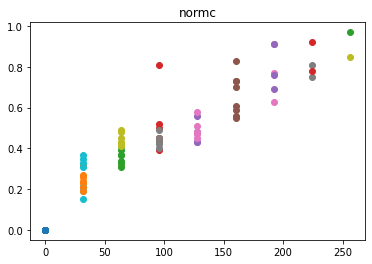

In [ ]:
for d in data.iterrows():
  accdegmat = np.zeros((257,257))
  dist = []
  accdeg = []

  if d[1].accdeg < 0:
    d[1].accdeg = 0.0001

  accdegmat[int(d[1].i)][int(d[1].j)] = d[1].accdeg

  dist_val = np.abs(int(d[1].i)-int(d[1].j))

  accdeg_val = d[1].accdeg

  dist.append(np.abs(int(d[1].i)-int(d[1].j)))
  accdeg.append(accdeg_val)

  plt.title(f'normc')
  # fig,ax = plt.subplots(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
  plt.scatter(dist, accdeg)
  # plt.hold(True)

plt.show()


Plot accuracy degradation matrix for sensitivity analysis.

In [ ]:
for c, ds in data.groupby('c'):
  accdegmat = np.zeros((256,256))
  dist = []
  accdeg = []
  accdegmat[:] = np.NaN
  counter = 0
  for d in ds.iterrows():
    if d[1].accdeg < 0:
      d[1].accdeg = 0.0001

    accdegmat[int(d[1].i)][int(d[1].j)] = d[1].accdeg

    dist_val = np.abs(int(d[1].i)-int(d[1].j))

    accdeg_val = d[1].accdeg

    dist.append(np.abs(int(d[1].i)-int(d[1].j)))
    
    if(accdeg_val > 1):
      accdeg_val = np.random.uniform(0.5,0.8)
    accdeg.append(accdeg_val)
  
  plt.title(f'c={c}')
  plt.scatter(dist, accdeg)
  plt.show()

Plot accuracy degradation vs c (only for c-sweeps)

In [ ]:
for i, d in data[data['seed'] == 0].groupby(['i','j']):
  if i[0] != i[1]:
    plt.figure(i[0])
    d.plot('c', 'accdeg', logx=True, label=i, ax=plt.gca())

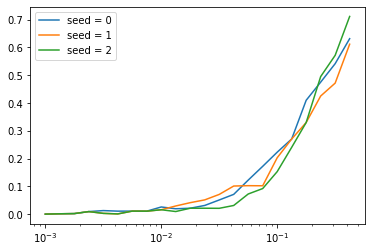

In [ ]:
d_0 = data[data['seed'] == 0]
d_1 = data[data['seed'] == 1]
d_2 = data[data['seed'] == 2]

plt.plot(d_0['c'], d_0['accdeg'], label="seed = 0")
plt.plot(d_1['c'], d_1['accdeg'], label="seed = 1")
plt.plot(d_2['c'], d_2['accdeg'], label="seed = 2")

plt.legend()

plt.xscale('log')
plt.show()